In [15]:
import csv
import random
import numpy as np
import matplotlib.pyplot as plt

from numpy.linalg import eig, norm, det
from scipy.linalg import inv
from scipy.stats import multivariate_normal

%matplotlib notebook

In [80]:
def ellipse(sigma, mean, scale=1):
    
    d, v = eig(inv(sigma))
    mat = v @ inv(np.sqrt(np.diag(d)))

    N = 200
    t = np.arange(0, N) * (2*np.pi) / N

    Y1 = scale * np.cos(t)
    Y2 = scale * np.sin(t)
   
    Y = np.array([Y1, Y2])

    X = mat.dot(Y)

    X1 = X[0]
    X2 = X[1]

    # move ellipse to mean_k
    X1 = X1 + mean[0]
    X2 = X2 + mean[1]
    
    return X1, X2

In [79]:
def plot(samples, parameters):

    data = samples.T
    gammas = parameters["gammas"]
    
    x = data[0]
    y = data[1]
    
    colors = [tuple(gammas[n]) for n in range(len(gammas))]
    scales = [2, 2, 2]
    
    # Create plot
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    
    ax.scatter(x, y, alpha=0.8, c=colors, edgecolors='none', s=30)
    
    for k in range(3):
        X1, X2 = ellipse(parameters["sigmas"][k], parameters["means"][k], scale=scales[k])
        ax.plot(X1, X2, c="black")
    
    plt.title('EM - 1,2,3')
    plt.show()

In [18]:
def get_random_means(train):

    train_a = train["1"]
    train_o = train["2"]
    train_u = train["3"]
    
    points_a = [train_a[random.randrange(0, len(train_a))] for i in range(5)]
    points_o = [train_o[random.randrange(0, len(train_o))] for i in range(5)]
    points_u = [train_u[random.randrange(0, len(train_u))] for i in range(5)]

    data = {
        "1": points_a,
        "2": points_o,
        "3": points_u
    }
    
    means = [
        np.mean(points_a, axis=0),
        np.mean(points_o, axis=0),
        np.mean(points_u, axis=0)
    ]
    
    return means, data

In [19]:
def get_sigma(data):

    d1 = data["1"]
    d2 = data["2"]
    d3 = data["3"]
    
    return (1/3) * (np.cov(d1, rowvar=False) + np.cov(d2, rowvar=False) + np.cov(d2, rowvar=False))

In [20]:
def parse():

    # parse data
    with open('a.txt') as f:
        lines_a = list(csv.reader(f, delimiter='\t'))

    with open('o.txt') as f:
        lines_o = list(csv.reader(f, delimiter='\t'))

    with open('u.txt') as f:
        lines_u = list(csv.reader(f, delimiter='\t'))

    lines_a = list(map(lambda x: [int(x[0]), int(x[1])],lines_a))
    lines_o = list(map(lambda x: [int(x[0]), int(x[1])],lines_o))
    lines_u = list(map(lambda x: [int(x[0]), int(x[1])],lines_u))

    # separate 'train' and 'test' datasets
    train_a = np.array(lines_a[:35])
    test_a = np.array(lines_a[35:])
    
    train_o = np.array(lines_o[:35])
    test_o = np.array(lines_o[35:])
    
    train_u = np.array(lines_u[:35])
    test_u = np.array(lines_u[35:])
    
    samples = np.array(list(train_a) + list(train_o) + list(train_u))
    
    data = {
        "train": {
            "1": train_a,
            "2": train_o,
            "3": train_u
        },
        "test": {
            "1": test_a,
            "2": test_o,
            "3": test_u
        }
    }
    
    return samples, data

In [21]:
samples, datasets = parse()

## EM

In [74]:
def calc_L(samples, means, sigmas, pi):
    
    x = samples
    
    return sum([np.log(sum([multivariate_normal.pdf(x[n], mean=means[k], cov=sigmas[k])*pi[k] for k in range(3)])) for n in range(len(samples))])

In [51]:
def calc_means(samples, gammas):

    # calc denominator
    den = calc_denom(gammas)
    
    m = np.array([sum([samples[n]*gammas[n][k] for n in range(len(samples))]) for k in range(3)])
    
    return np.array([m[i]/den[i] for i in range(len(m))])

In [65]:
def calc_sigmas(samples, means, gammas):

    # calc denominator
    den = calc_denom(gammas)
    
    sigmas = []
    sigmas_k = []
    
    for k in range(3):
        for n in range(len(samples)):
            res = np.array(list(map(lambda y: [y], samples[n]-means[k])))
            s = gammas[n][k] * res @ res.T
            sigmas_k.append(s)
        sigmas.append(sum(sigmas_k) / den[k])
        sigmas_k.clear()
    
    return sigmas

In [46]:
def calc_pi(gammas, N):

    num = calc_denom(gammas)
    
    return num / N

In [47]:
# calculates the sum of gammas
# for all the classses
# returns:
#   [sum(gammas[0]), sum(gammas[1]), sum(gammas[2])]
def calc_denom(gammas):

    N = len(gammas)
    
    d = np.array([sum([gammas[n][k] for n in range(N)]) for k in range(3)])
    
    return d

In [48]:
def gamma(sample, means, sigmas, pi):
    
    nums = np.array([multivariate_normal.pdf(sample, mean=means[k], cov=sigmas[k])*pi[k] for k in range(3)])

    den = nums.sum()
    
    return nums / den

In [49]:
def em(samples, means, sigmas, pi):

    L = np.zeros(2)
    
    L[0] = 0.0
    L[1] = calc_L(samples, means, sigmas, pi)
    deltaL = L[1] - L[0]
    
    while abs(deltaL) > 0.01:

        ############
        # 'E' step #
        ############
        gammas = np.array([gamma(samples[i], means, sigmas, pi) for i in range(len(samples))])

        ############
        # 'M' step #
        ############
        
        # calc new means
        means = calc_means(samples, gammas)

        # calc new sigmas
        sigmas = calc_sigmas(samples, means, gammas)

        # calc new pi
        pi = calc_pi(gammas, len(samples))

        L[0] = L[1]
        L[1] = calc_L(samples, means, sigmas, pi)
        deltaL = L[1] - L[0]

    return means, sigmas, gammas

## EM classification

In [82]:
# obtain first means
# by calc the mean of 5 random
# points in samples
means, data = get_random_means(datasets["train"])

# obtain first sigmas
# by calc the average of the sigma
# of each class
sigma = get_sigma(data)

sigmas = np.array([sigma, sigma, sigma])
pi = np.array([(1/3) for i in range(3)])

means, sigmas, gammas = em(samples, means, sigmas, pi)

## Plotting

<IPython.core.display.Javascript object>


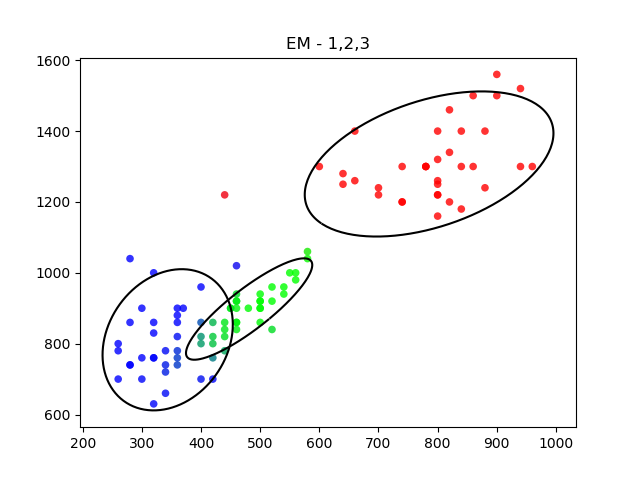

In [83]:
parameters = {
    "means": means,
    "sigmas": sigmas,
    "gammas": gammas
}

plot(samples, parameters)